In [30]:
import gc
gc.collect()
from typing import Type
from pydantic import confloat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import geopandas as gpd
import h3
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
import uuid
import warnings
warnings.filterwarnings('ignore')
import datetime
import shapely.speedups
import statsmodels.formula.api as smf
from shapely.geometry import Polygon


In [2]:
## Structuring & adding needed columns
school = pd.read_csv('/Users/shilpa/Documents/UNICEF/data/school/kazakshtan/kazakhstan_gov_042021_rur.csv', header=0)
pop = pd.read_csv("/Users/shilpa/Documents/UNICEF/data/socio-economic/kazakshtan/raw/population_kaz_2018-10-01.csv", header=0)
eco = pd.read_csv("/Users/shilpa/Documents/UNICEF/data/socio-economic/kazakshtan/raw/kaz_relative_wealth_index.csv", header=0)
countries_gdf = gpd.read_file("/Users/shilpa/Documents/UNICEF/data/gadm/gadm36_KAZ_gpkg/gadm36_KAZ.gpkg", layer='gadm36_KAZ_0')


In [3]:
print(school['connectivity_speed'].isna().sum())
print(school.head())
print(eco['error'].describe(include='all'))
school['rur'] = np.where((school['fid'].isna()==True), "rural", "urban")
print(school['rur'].value_counts())
school = school.drop(['field_13','fid','ID_HDC_G0', 'NAME_MAIN', 'NAME_LIST', 'POP_2015','BU_2015'], axis = 1)


29
   school_id               admin1              admin2         admin3  \
0          0  Акмолинская область    Степногорск Г.А.  г.Степногорск   
1          1  Акмолинская область   Aршалынский район       п.Аршалы   
2          2  Акмолинская область   Атбасарский район      г.Атбасар   
3          3  Акмолинская область   Жаркаинский район   г.Державинск   
4          4  Акмолинская область  Зерендинский район    с.Гранитный   

                                                name  num_students        lat  \
0  КГУ "Вечерняя (сменная) средняя общеобразовате...          60.0  52.469684   
1  ГУ"Вечерняя (сменная) средняя общеобразователь...          15.0  50.832731   
2  ГУ "Вечерняя (сменная) общеобразовательная сре...          68.0  51.775718   
3  ГУ "Жаркаинская вечерняя (сменная) общеобразов...          26.0  51.098673   
4  ГУ "Вечерняя (сменная) средняя общеобразовател...          79.0  53.434238   

         lon  num_computers  num_computers_education  num_interactive_boards 

In [4]:
print(school.head())
print(pop.head())
print(eco.head())

#Add hex id
list_hex_res = []
for i in range(0, len(school)):
    # index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat = school['lat'][i],
                     lng = school['lon'][i],
                     resolution = 7)
    list_hex_res.append(h)

school['hex7'] = list_hex_res

#Add hex id
list_hex_res = []
for i in range(0, len(pop)):
    # index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat = pop['latitude'][i],
                     lng = pop['longitude'][i],
                     resolution = 7)
    list_hex_res.append(h)

pop['hex7'] = list_hex_res


#Add hex id
list_hex_res = []
for i in range(0, len(eco)):
    # index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat = eco['latitude'][i],
                     lng = eco['longitude'][i],
                     resolution = 7)
    list_hex_res.append(h)

eco['hex7'] = list_hex_res



   school_id               admin1              admin2         admin3  \
0          0  Акмолинская область    Степногорск Г.А.  г.Степногорск   
1          1  Акмолинская область   Aршалынский район       п.Аршалы   
2          2  Акмолинская область   Атбасарский район      г.Атбасар   
3          3  Акмолинская область   Жаркаинский район   г.Державинск   
4          4  Акмолинская область  Зерендинский район    с.Гранитный   

                                                name  num_students        lat  \
0  КГУ "Вечерняя (сменная) средняя общеобразовате...          60.0  52.469684   
1  ГУ"Вечерняя (сменная) средняя общеобразователь...          15.0  50.832731   
2  ГУ "Вечерняя (сменная) общеобразовательная сре...          68.0  51.775718   
3  ГУ "Жаркаинская вечерняя (сменная) общеобразов...          26.0  51.098673   
4  ГУ "Вечерняя (сменная) средняя общеобразовател...          79.0  53.434238   

         lon  num_computers  num_computers_education  num_interactive_boards  \


In [5]:
grid = school.groupby(["hex7"], as_index=False).agg(school_count_all=('school_id', 'size'))
school_r = school.loc[school['rur'] == 'rural']
school_u = school.loc[school['rur'] != 'rural']
school_r_grid = school_r.groupby(["hex7"], as_index=False).agg(school_count_r=('school_id', 'size'))
school_u_grid = school_u.groupby(["hex7"], as_index=False).agg(school_count_u=('school_id', 'size'))

df0 = pd.merge(school_r_grid,school_u_grid,on='hex7',how="outer")
df = pd.merge(df0,grid,on='hex7',how="outer")
df['school_count_r'].loc[df['school_count_r'].isna()==True] = 0
df['school_count_u'].loc[df['school_count_u'].isna()==True] = 0
df['rural_per'] = df['school_count_r']/df['school_count_all']
print(df['rural_per'].describe(include='all'))
df['rural_per'].loc[df['rural_per']>0.5] = 1
df['rural_per'].loc[df['rural_per']<=0.5] = 0
display(df.loc[(df['rural_per'] != 0) & (df['rural_per'] != 1)])
df['rur'] = ""
df['rur'].loc[df['rural_per']==1] = "rural"
df['rur'].loc[df['rural_per']==0] = "urban"
df['rur'].loc[(df['rural_per']!=0) & (df['rural_per']!=1)] = "semi-urban"
print(df['rur'].value_counts())


count    5093.000000
mean        0.946539
std         0.221681
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: rural_per, dtype: float64


,hex7,school_count_r,school_count_u,school_count_all,rural_per


rural    4812
urban     281
Name: rur, dtype: int64


In [6]:
## Aggregates
school_grid = school.groupby("hex7").agg( connectivity_speed=pd.NamedAgg(column="connectivity_speed", aggfunc="mean"),)
pop_grid = pop.groupby("hex7").agg(population_2020=pd.NamedAgg(column="population_2020", aggfunc="sum"),pop_count=pd.NamedAgg(column="population_2020", aggfunc="size"),)
eco_grid = eco.groupby("hex7").agg(rwi=pd.NamedAgg(column="rwi", aggfunc="mean"),eco_count=pd.NamedAgg(column="rwi", aggfunc="size"),error=pd.NamedAgg(column="error", aggfunc="mean"),)


In [24]:
## Merge
df1 = pd.merge(school_grid,pop_grid,on='hex7')
df2 = pd.merge(df1,eco_grid,on='hex7')
df3 = pd.merge(df2,df,on='hex7')


In [25]:
## Analysis
display(df3.corr())
df3['rwi_min'] = df3['rwi'] + min(df3['rwi'])
columns = ['connectivity_speed', 'population_2020', 'rwi_min','error']
for col in columns:
    df3["log_"+col] = np.log(df3[col])
df_r = df3.loc[df3['rur'] == 'rural']
df_u = df3.loc[df3['rur'] == 'urban']
    
lm_log = smf.ols('log_connectivity_speed~log_population_2020+log_rwi_min+log_error+rur', data=df3).fit()
lm = smf.ols('connectivity_speed~population_2020+rwi+error+rur', data=df3).fit()
lmr = smf.ols('connectivity_speed~population_2020+rwi+error', data=df_r).fit()
lmu = smf.ols('connectivity_speed~population_2020+rwi+error', data=df_u).fit()

print(lm_log.summary())
print(lm.summary())
print(lmr.summary())
print(lmu.summary())


,connectivity_speed,population_2020,pop_count,rwi,eco_count,error,school_count_r,school_count_u,school_count_all,rural_per
connectivity_speed,1.000000,0.283000,0.310730,0.346792,0.195541,0.334728,0.045500,0.170462,0.183616,-0.231032
population_2020,0.283000,1.000000,0.765672,0.585376,0.280059,0.366869,-0.037103,0.613693,0.539518,-0.699016
pop_count,0.310730,0.765672,1.000000,0.678640,0.378116,0.479995,0.138637,0.507197,0.548289,-0.612935
rwi,0.346792,0.585376,0.678640,1.000000,0.272614,0.517569,0.110360,0.398300,0.431470,-0.503429
eco_count,0.195541,0.280059,0.378116,0.272614,1.000000,0.211013,0.099953,0.164763,0.211326,-0.221203
error,0.334728,0.366869,0.479995,0.517569,0.211013,1.000000,0.129118,0.196524,0.258049,-0.262258
school_count_r,0.045500,-0.037103,0.138637,0.110360,0.099953,0.129118,1.000000,-0.184445,0.435913,0.260408
school_count_u,0.170462,0.613693,0.507197,0.398300,0.164763,0.196524,-0.184445,1.000000,0.804146,-0.700320
school_count_all,0.183616,0.539518,0.548289,0.431470,0.211326,0.258049,0.435913,0.804146,1.000000,-0.483785
rural_per,-0.231032,-0.699016,-0.612935,-0.503429,-0.221203,-0.262258,0.260408,-0.700320,-0.483785,1.000000


                              OLS Regression Results                              
Dep. Variable:     log_connectivity_speed   R-squared:                       0.213
Model:                                OLS   Adj. R-squared:                  0.183
Method:                     Least Squares   F-statistic:                     7.224
Date:                    Thu, 24 Jun 2021   Prob (F-statistic):           3.45e-05
Time:                            19:13:25   Log-Likelihood:                 3.9774
No. Observations:                     112   AIC:                             2.045
Df Residuals:                         107   BIC:                             15.64
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

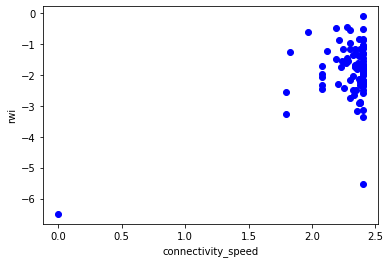

In [43]:
plt.plot(df_u['log_connectivity_speed'], df_u['log_rwi_min'], 'bo') 
plt.ylabel("rwi")
plt.xlabel("connectivity_speed")
plt.savefig('Graph.pdf') 
plt.show() 

In [123]:
list_hex_res = []

for i in range(0, len(df3)):
    h = h3.h3_to_geo_boundary(df3['hex7'][i], True)
    list_hex_res.append(Polygon(h))

df3['geometry'] = list_hex_res

gdf = gpd.GeoDataFrame(df3, crs='EPSG:4326')


In [124]:
gdf_r = gdf.loc[df3['rur'] == 'rural']
gdf_u = gdf.loc[df3['rur'] == 'urban']

In [125]:
gdf.to_file('/Users/shilpa/Documents/UNICEF/projects/mapbox/kazakhstan_analysis.geojson', driver='GeoJSON')
gdf_r.to_file('/Users/shilpa/Documents/UNICEF/projects/mapbox/kazakhstan_analysis_rural.geojson', driver='GeoJSON')
gdf_u.to_file('/Users/shilpa/Documents/UNICEF/projects/mapbox/kazakhstan_analysis_urban.geojson', driver='GeoJSON')
